In [0]:
!pip install -q tf-nightly

In [0]:
from __future__ import absolute_import, division, print_function

from tensorflow import feature_column as fc

import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)


dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [41]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [42]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [43]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

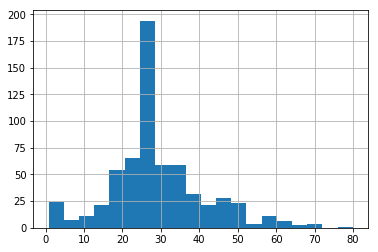

In [44]:
dftrain.age.hist(bins=20);

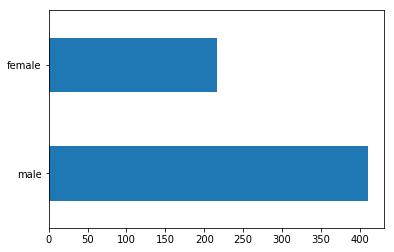

In [45]:
dftrain.sex.value_counts().plot(kind='barh');

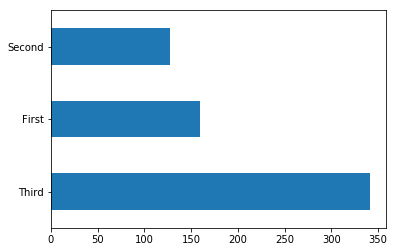

In [46]:
(dftrain['class']
.value_counts()
.plot(kind='barh'));

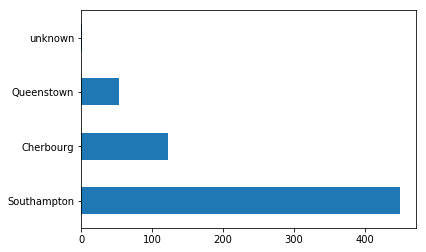

In [47]:
(dftrain['embark_town']
.value_counts()
.plot(kind='barh'));

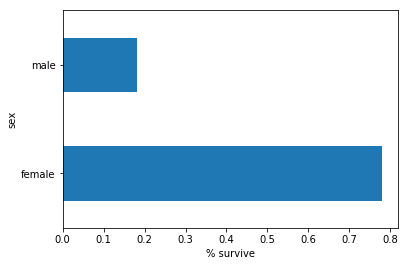

In [48]:
ax = (pd.concat([dftrain, y_train], axis=1)\
     .groupby('sex')
     .survived
     .mean()
     .plot(kind='barh'))
ax.set_xlabel('% survive');

In [0]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
  
def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [59]:
example = dftrain.head(1)
class_fc = one_hot_cat_column('class',('First', 'Second', 'Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', fc.input_layer(dict(example), [class_fc]).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


In [88]:
fc.input_layer(dict(example), feature_columns).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [0]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset= dataset.shuffle(NUM_EXAMPLES)
      
    dataset = dataset.repeat(n_epochs)
    
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [89]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

linear_est.train(train_input_fn, max_steps=100)

results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.78409094
Dummy model:  0.625


In [90]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                         n_batches_per_layer=n_batches)

est.train(train_input_fn, max_steps=100)

results = est.evaluate(eval_input_fn)
print('Accuracy: ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy:  0.82575756
Dummy model:  0.625


In [91]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.78409094
Dummy model:  0.625


In [92]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.82575756
Dummy model:  0.625


In [86]:
def make_inmemory_train_input_fn(X, y):
  def input_fn():
    return dict(X), y
  return input_fn


train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
est = tf.contrib.estimator.boosted_trees_classifier_train_in_memory(
    train_input_fn,
    feature_columns)
print(est.evaluate(eval_input_fn)['accuracy'])

ValueError: ignored

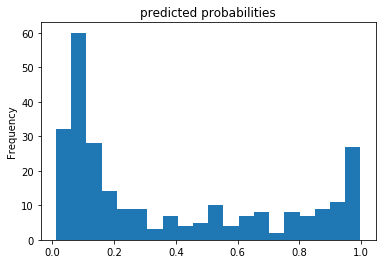

In [93]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

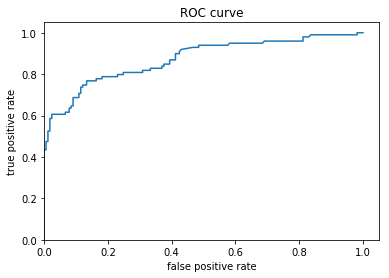

In [94]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _= roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);